In [5]:
! pip install ultralytics

In [6]:
from ultralytics import YOLO
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import os
from torchvision import transforms
import torch.nn.functional as F
from datetime import datetime
import random
import math
import csv

In [7]:
yolo = YOLO("/kaggle/input/earthcam-yolo/best.pt", verbose = False)

In [8]:
# define paths to image folders
folder_paths = {
    'New York': '/kaggle/input/earthcam-yolo/Earthcam_Images/Earthcam_Images/NewYork_raw',
    'New Orleans': '/kaggle/input/earthcam-yolo/Earthcam_Images/Earthcam_Images/NewOrleans_raw',
    'London': '/kaggle/input/earthcam-yolo/Earthcam_Images/Earthcam_Images/London_raw'
}

In [9]:
def count_people_from_yolo(image_path, model):
    # Perform inference
    results = model(image_path, verbose = False)
    
    # Access the first result in the list of results
    detections = results[0]
    
    # Extract bounding boxes and class IDs
    class_ids = detections.boxes.cls.cpu().numpy()  # Class IDs
    
    # Count the number of people detected
    person_count = sum(class_id == 0 for class_id in class_ids)  # Class ID 0 for 'person'
    
    return person_count

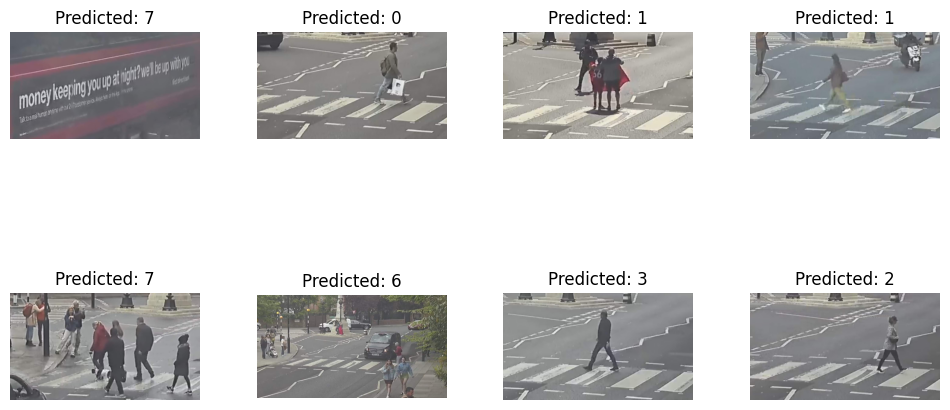

In [10]:
# visualize how model works on the images

def visualize_prediction(model, city, year, number_of_images):
    image_dir = folder_paths[city]
    image_files = []
    for filename in os.listdir(image_dir):
        if filename.endswith(".jpg"):
            parts = filename.split('_')
            city_name = parts[0]
            date = parts[1]
            file_year = date.split('-')[-1]
            if file_year == year:
                image_files.append(filename)
    
    # Randomly select indices
    random_indices = random.sample(range(len(image_files)), number_of_images)
    
    rows = math.ceil(number_of_images / 4)
    cols = min(4, number_of_images)

    fig, axes = plt.subplots(rows, cols, figsize=(12, 3 * rows))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    for i, idx in enumerate(random_indices):
        filename = image_files[idx]
        image_path = os.path.join(image_dir, filename)
        predicted_count = count_people_from_yolo(image_path, model)
        image = Image.open(image_path).convert('RGB')

        if rows == 1 and cols == 1:
            ax = axes
        elif rows == 1 or cols == 1:
            ax = axes[i]
        else:
            ax = axes[i // cols, i % cols]

        ax.imshow(image)
        ax.set_title(f"Predicted: {int(predicted_count)}")
        ax.axis('off')

    plt.show()

# Visualize the prediction for the first image in the validation set
visualize_prediction(yolo, "London", "2022", number_of_images=8)

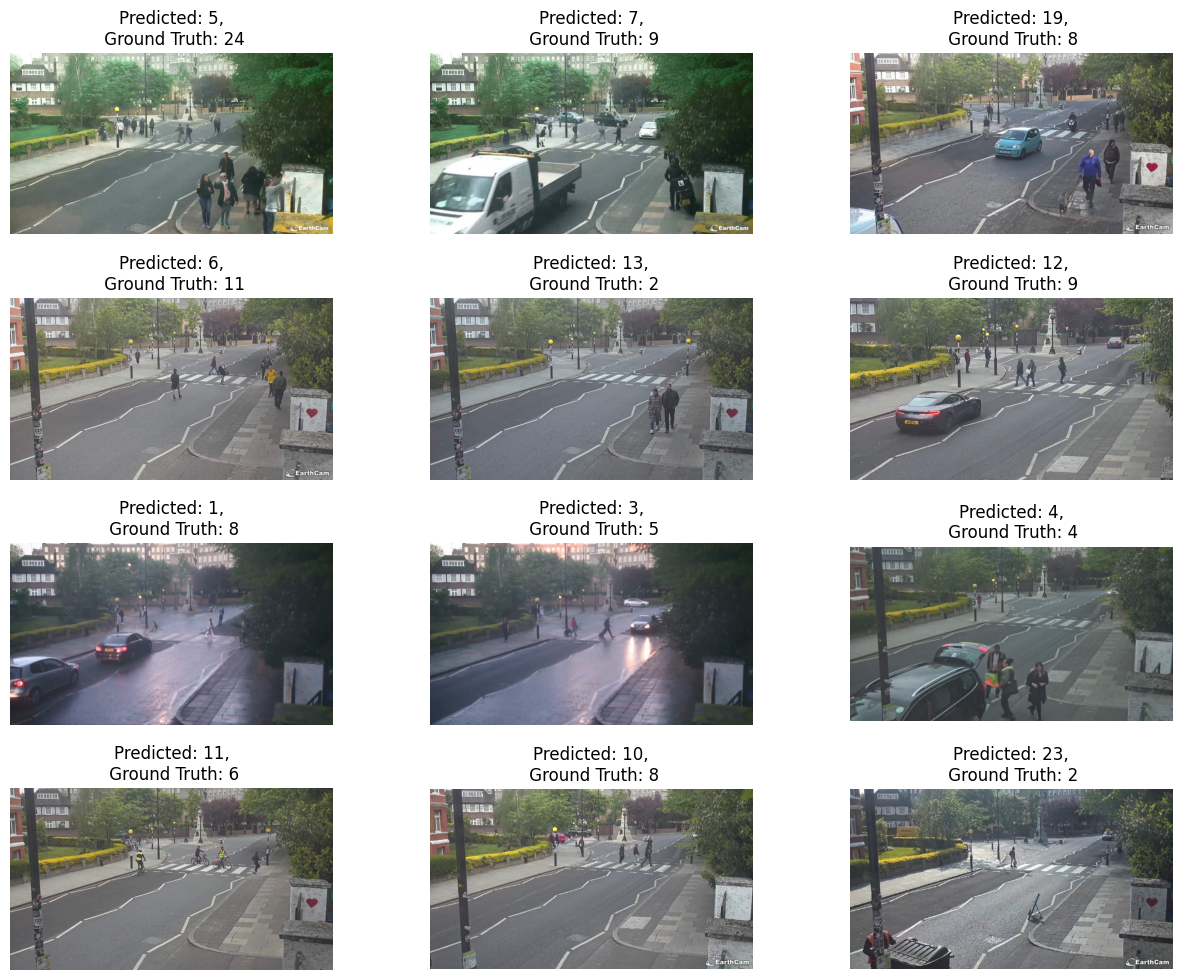

In [14]:
def load_ground_truth(file_path):
    ground_truth = {}
    with open(file_path, mode='r') as file:
        if file_path.endswith('.csv'):
            reader = csv.reader(file)
            next(reader)  # Skip the header
            for row in reader:
                filename, count = row
                ground_truth[filename] = int(count)
        elif file_path.endswith('.json'):
            ground_truth = json.load(file)
    return ground_truth

def visualize_ground_truth_predictions(model, ground_truth_file, city):
    # Load the ground truth data
    ground_truth = load_ground_truth(ground_truth_file)
    
    # Set the directory where images are stored
    image_dir = folder_paths[city]
    
    # Determine the number of images
    number_of_images = len(ground_truth)
    
    # Set up the plot grid
    rows = math.ceil(number_of_images / 3)
    cols = min(3, number_of_images)
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    for i, (filename, gt_count) in enumerate(ground_truth.items()):
        image_path = os.path.join(image_dir, filename)
        predicted_count = count_people_from_yolo(image_path, model)
        image = Image.open(image_path).convert('RGB')
        
        if rows == 1 and cols == 1:
            ax = axes
        elif rows == 1 or cols == 1:
            ax = axes[i]
        else:
            ax = axes[i // cols, i % cols]
        
        ax.imshow(image)
        ax.set_title(f"Predicted: {int(predicted_count)},\n Ground Truth: {gt_count}")
        ax.axis('off')
    
    plt.show()

# Example usage:
visualize_ground_truth_predictions(yolo, '/kaggle/input/earthcam-yolo/ground_truth_London_filtered.csv', "London")

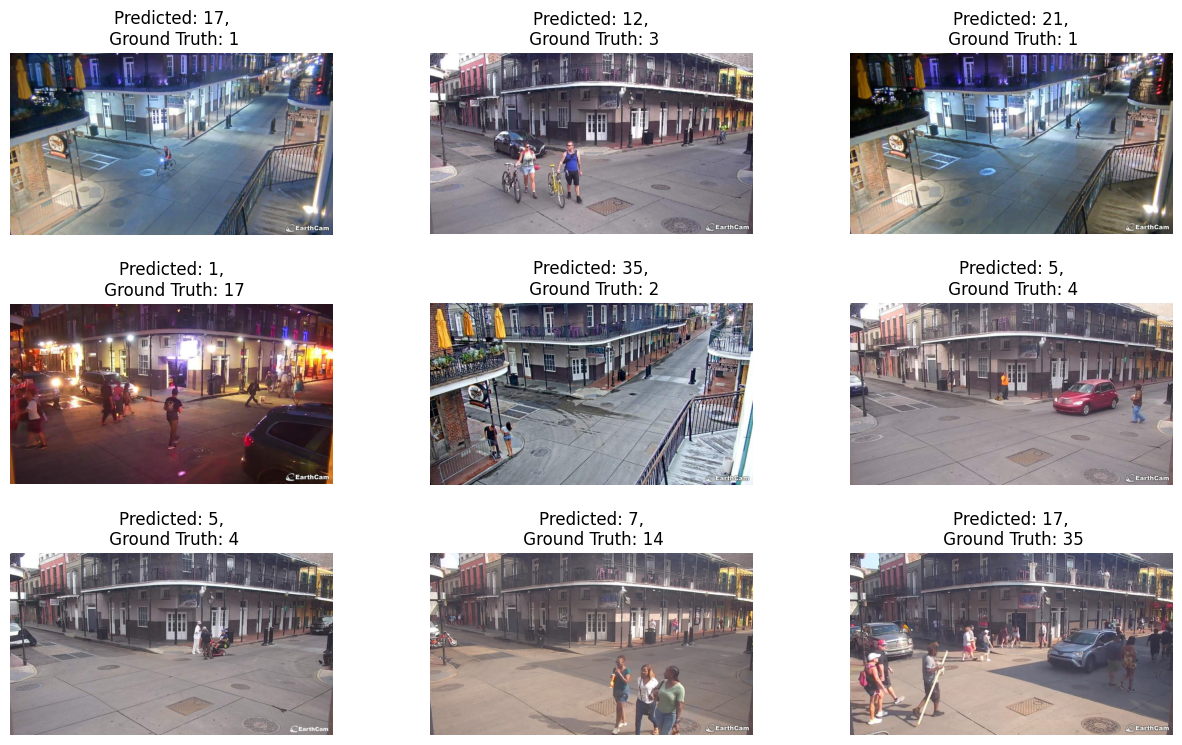

In [20]:
visualize_ground_truth_predictions(yolo, '/kaggle/input/earthcam-yolo/ground_truth_New_Orleans_filtered.csv', "New Orleans")

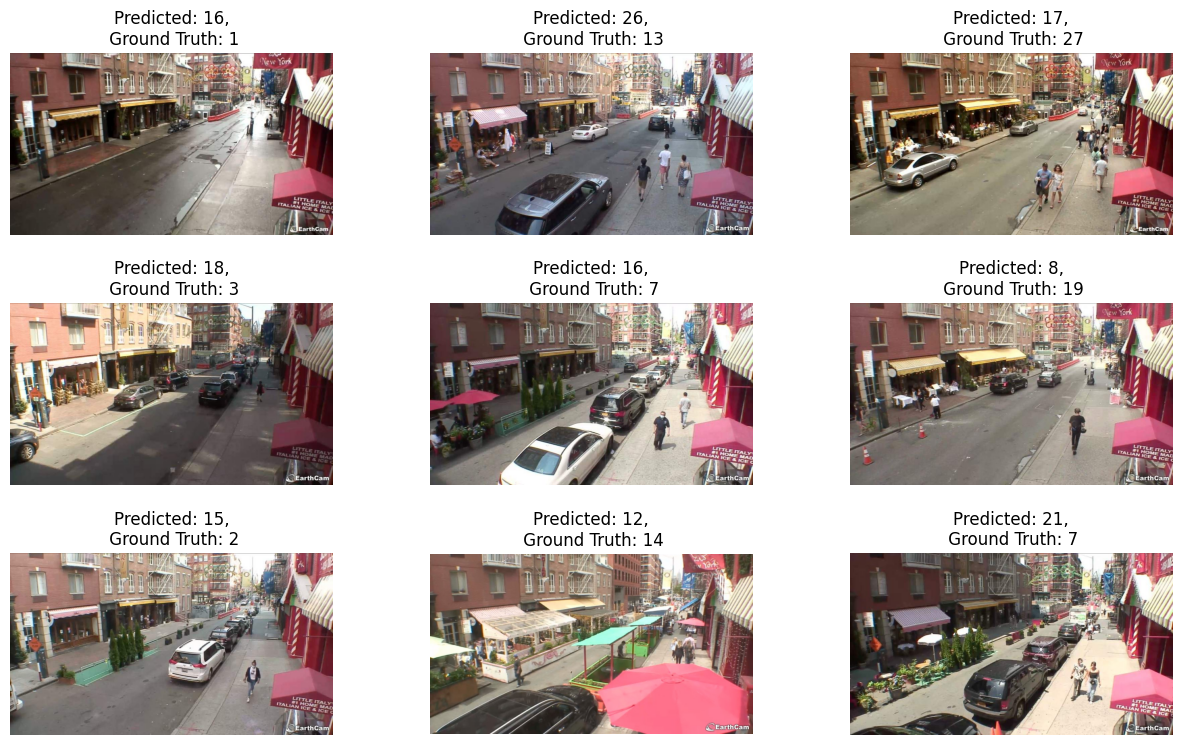

In [23]:
visualize_ground_truth_predictions(yolo, '/kaggle/input/earthcam-yolo/ground_truth_New_York_filtered.csv', "New York")